# **DIRECTED GRAPHICAL MODELS**
*Import necessary Libraries*

In [98]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import pprint
from tabulate import tabulate
from sympy import Symbol  

*Define variable names and their indices*

In [99]:
VARIABLES = {
    0: "IsSummer",
    1: "HasFlu",
    2: "HasFoodPoisoning",
    3: "HasHayFever",
    4: "HasPneumonia",
    5: "HasRespiratoryProblems",
    6: "HasGastricProblems",
    7: "HasRash",
    8: "Coughs",
    9: "IsFatigued",
    10: "Vomits",
    11: "HasFever",
}

# Reverse mapping for index-based access
VARIABLE_INDICES = {v: i for i, v in VARIABLES.items()}


*Load data from file with integer-encoded variable assignments*

In [100]:
def load_data(filename, handle_missing=False):
  kwargs = {}
  if handle_missing:
    kwargs["na_values"] = ["NA", ""]
  data = pd.read_csv(filename, header=None, names=["assignment"], **kwargs)
  return data
# Load training data
dataset = load_data(r'C:\Users\hp\Desktop\SecondAI\PGM\HW2\medical\dataset.dat')

# Load true joint probability data
true_joint_data = pd.read_csv("medical/joint.dat",names=["assignment", "probability"], sep="\t", dtype={"probability": float})


*Explore(print) the loaded data*

In [101]:
print("Dataset:")
# Print the first few rows of the dataset
print(dataset.head())
print("\nJoint Probability Data:")
 # Print the first few rows of the joint data
print(true_joint_data.head())


Dataset:
   assignment
0           1
1         136
2           8
3           0
4         129

Joint Probability Data:
   assignment  probability
0           0     0.294259
1           1     0.102216
2           2     0.003831
3           3     0.000255
4           4     0.023354


In [102]:
print("Dataset shape:", dataset.shape)
print("Joint data shape:", true_joint_data.shape)

Dataset shape: (4000000, 1)
Joint data shape: (4096, 2)


In [103]:
print("Dataset data types:")
print(dataset.dtypes)
print("\nJoint data data types:")
print(true_joint_data.dtypes)

Dataset data types:
assignment    int64
dtype: object

Joint data data types:
assignment       int64
probability    float64
dtype: object


# 1. Represent the Directed Graphical Model

In [104]:
class DGM:
  def __init__(self):
    # Define parent-child relationships (variable index: list of parent indices)
    self.parent_map = {
        VARIABLE_INDICES["IsSummer"]: [],
        VARIABLE_INDICES["HasFoodPoisoning"]: [],
        VARIABLE_INDICES["HasHayFever"]: [VARIABLE_INDICES["IsSummer"]],
        VARIABLE_INDICES["HasFlu"]: [VARIABLE_INDICES["Coughs"],VARIABLE_INDICES["IsFatigued"]],
        VARIABLE_INDICES["HasPneumonia"]: [VARIABLE_INDICES["HasRespiratoryProblems"]],
        VARIABLE_INDICES["HasRespiratoryProblems"]: [VARIABLE_INDICES["HasFlu"],VARIABLE_INDICES["IsFatigued"], VARIABLE_INDICES["HasPneumonia"], VARIABLE_INDICES["IsSummer"]],
        VARIABLE_INDICES["HasGastricProblems"]: [VARIABLE_INDICES["HasFoodPoisoning"]],
        VARIABLE_INDICES["HasRash"]: [VARIABLE_INDICES["HasFoodPoisoning"], VARIABLE_INDICES["HasHayFever"]],
        VARIABLE_INDICES["Coughs"]: [VARIABLE_INDICES["HasPneumonia"],VARIABLE_INDICES["HasFlu"], VARIABLE_INDICES["HasRespiratoryProblems"]],
        VARIABLE_INDICES["IsFatigued"]: [VARIABLE_INDICES["HasFlu"], VARIABLE_INDICES["HasPneumonia"], VARIABLE_INDICES["Coughs"]],
        VARIABLE_INDICES["Vomits"]: [VARIABLE_INDICES["Coughs"], VARIABLE_INDICES["HasFever"],VARIABLE_INDICES["HasFoodPoisoning"], VARIABLE_INDICES["HasGastricProblems"]],
        VARIABLE_INDICES["HasFever"]: [VARIABLE_INDICES["IsSummer"],VARIABLE_INDICES["HasFlu"], VARIABLE_INDICES["HasPneumonia"],VARIABLE_INDICES["HasFoodPoisoning"],VARIABLE_INDICES["Vomits"]],
    }
    # Initialize empty CPTs (Conditional Probability Tables)
    self.cpts = {var: {} for var in self.parent_map.keys()}

  def get_parents(self, variable):
    """Returns the list of parent indices for a given variable."""
    return self.parent_map[variable]
    
  def display_model(self):
    for child, parents in self.parent_map.items():
      if parents:
        parent_symbols = [Symbol(VARIABLES[p]) for p in parents]  # Create symbolic variables for parents (optional)
        equation_left = f"p({VARIABLES[child]} | " + ', '.join([str(s) for s in parent_symbols]) + ")"
      else:
        equation_left = f"p({VARIABLES[child]})"
      print(f"{equation_left} = {self.cpts[child]}")

  def get_probability(self, assignment):
    if len(assignment) != len(self.parent_map):
      raise ValueError("Invalid assignment length. Expected {} values.".format(len(self.parent_map)))

    probability = 1.0  # Initialize with 1 for multiplication

    for var, value in assignment.items():
      # Check if value is boolean
      if not isinstance(value, bool):
        raise ValueError("Assignment values must be True or False.")

      parents = self.get_parents(var)
      parent_values = tuple(assignment[p] for p in parents)
      # Look up conditional probability from CPT
      try:
        cpt_entry = self.cpts[var][parent_values]
        probability *= cpt_entry[value]  # Probability of current variable given parents
      except KeyError:
        # Handle missing CPT entries (e.g., with a default probability or raising an error)
        raise KeyError("Missing CPT entry for variable {} with parent values {}".format(var, parent_values))

    return probability


*Function to Visualize the graph*

In [105]:
def visualize_graph(parent_map, variable_names):
    G = nx.DiGraph()
    for child, parents in parent_map.items():
        for parent in parents:
            G.add_edge(variable_names[parent], variable_names[child])

    # Define colors for nodes
    colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'gray', 'cyan', 'magenta', 'brown', 'lime']
    node_colors = [colors[i % len(colors)] for i in range(len(G.nodes()))]

    pos = nx.kamada_kawai_layout(G)  # Use kamada_kawai_layout instead of spring_layout
    nx.draw(G, pos, node_color=node_colors)

    # Create a legend
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=node,
                                   markerfacecolor=color, markersize=10) for node, color in zip(G.nodes(), node_colors)],
               title="Variables", bbox_to_anchor=(1, 1), loc='upper left')

    plt.show()

*Display the parent-child relationships and the conditional probabilities *

In [106]:
dgm = DGM()
dgm.display_model()

p(IsSummer) = {}
p(HasFoodPoisoning) = {}
p(HasHayFever | IsSummer) = {}
p(HasFlu | Coughs, IsFatigued) = {}
p(HasPneumonia | HasRespiratoryProblems) = {}
p(HasRespiratoryProblems | HasFlu, IsFatigued, HasPneumonia, IsSummer) = {}
p(HasGastricProblems | HasFoodPoisoning) = {}
p(HasRash | HasFoodPoisoning, HasHayFever) = {}
p(Coughs | HasPneumonia, HasFlu, HasRespiratoryProblems) = {}
p(IsFatigued | HasFlu, HasPneumonia, Coughs) = {}
p(Vomits | Coughs, HasFever, HasFoodPoisoning, HasGastricProblems) = {}
p(HasFever | IsSummer, HasFlu, HasPneumonia, HasFoodPoisoning, Vomits) = {}


In [107]:
print(VARIABLE_INDICES)

{'IsSummer': 0, 'HasFlu': 1, 'HasFoodPoisoning': 2, 'HasHayFever': 3, 'HasPneumonia': 4, 'HasRespiratoryProblems': 5, 'HasGastricProblems': 6, 'HasRash': 7, 'Coughs': 8, 'IsFatigued': 9, 'Vomits': 10, 'HasFever': 11}


*Visualize DGM*

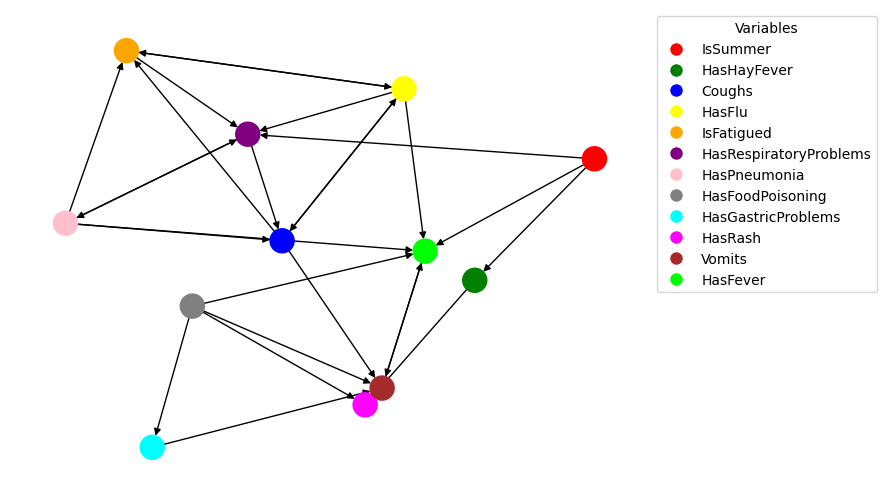

In [108]:
dgm = DGM()
visualize_graph(dgm.parent_map, VARIABLES)

# 2. Estimates Parameters

In [109]:
def estimate_cpts(model, data, smoothing_constant=1):
  cpts = {}
  for var, parents in model.parent_map.items():
    # Initialize empty dictionary for CPT entries (combinations of parent values and child values)
    cpt = {}
    total_counts = {}
    for assignment in data["assignment"]:
      # Convert assignment integer to list of booleans
      assignment_values = [bool(int(x)) for x in format(assignment, '012b')]
      parent_values = [assignment_values[p] for p in parents]  # Get parent values
      child_value = assignment_values[var]  # Get child value
      # Create a key for the CPT entry based on parent and child values
      key = tuple(parent_values)
      cpt[key] = cpt.get(key, {True: smoothing_constant, False: 0})
      cpt[key][child_value] += 1  # Count occurrences of this combination
      total_counts[key] = total_counts.get(key, 0) + 1

    # Normalize counts to obtain probabilities
    for key, counts in cpt.items():
      cpt[key] = {k: v / total_counts[key] for k, v in counts.items()}
    cpts[var] = cpt

  return cpts


In [110]:
model = DGM()
data= dataset
cpts = estimate_cpts(model, data)


In [111]:
print(model.parent_map)

{0: [], 2: [], 3: [0], 1: [8, 9], 4: [5], 5: [1, 9, 4, 0], 6: [2], 7: [2, 3], 8: [4, 1, 5], 9: [1, 4, 8], 10: [8, 11, 2, 6], 11: [0, 1, 4, 2, 10]}


In [112]:
def visualize_cpts(model, cpts):
  """
  This function visualizes the conditional probability tables (CPTs) for each variable in a tabular format.

  Args:
      model: The DGM model object.
      cpts: The estimated conditional probability tables.
  """
  from tabulate import tabulate  # Import library for creating tables

  for var, parent_map in model.parent_map.items():
    if not parent_map:  # Skip variables without parents (no CPT to visualize)
      continue
    parent_names = [VARIABLES[p] for p in parent_map]  # Get parent variable names
    num_parents = len(parent_names)
    
    # Create a list of rows for the table
    table_data = []
    for parent_assignment in itertools.product([0, 1], repeat=num_parents):
      # Convert assignment from 0/1 to True/False
      parent_values = [bool(val) for val in parent_assignment]
      probability_true = cpts[var][tuple(parent_values)][True]
      probability_false = cpts[var][tuple(parent_values)][False]
      table_data.append([*parent_values, probability_true, probability_false])  # Combine parent values and probabilities

    # Create table headers
    table_headers = ["Parent " + str(i+1) for i in range(num_parents)] + ["P(True)", "P(False)"]
    
    # Print the table using tabulate library
    print(f"CPT for {VARIABLES[var]}:")
    print(tabulate(table_data, headers=table_headers, tablefmt="grid"))
    print("\n")  # Add a newline for better readability between tables


In [113]:
visualize_cpts(model, cpts)

CPT for HasHayFever:
+------------+-----------+------------+
| Parent 1   |   P(True) |   P(False) |
+============+===========+============+
| False      |  0.178165 |   0.821835 |
+------------+-----------+------------+
| True       |  0.35102  |   0.648985 |
+------------+-----------+------------+


CPT for HasFlu:
+------------+------------+-----------+------------+
| Parent 1   | Parent 2   |   P(True) |   P(False) |
+============+============+===========+============+
| False      | False      |  0.076717 |   0.923283 |
+------------+------------+-----------+------------+
| False      | True       |  0.281409 |   0.718594 |
+------------+------------+-----------+------------+
| True       | False      |  0.076461 |   0.92354  |
+------------+------------+-----------+------------+
| True       | True       |  0.28232  |   0.717692 |
+------------+------------+-----------+------------+


CPT for HasPneumonia:
+------------+-----------+------------+
| Parent 1   |   P(True) |   P(Fal

In [114]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(cpts)

{   0: {(): {False: 0.9471925, True: 0.05280775}},
    1: {   (False, False): {   False: 0.9232833916582366,
                               True: 0.07671695561716221},
           (False, True): {False: 0.7185940795126142, True: 0.2814090447551355},
           (True, False): {   False: 0.9235403505019769,
                              True: 0.07646103828468183},
           (True, True): {False: 0.7176920299328876, True: 0.2823204213514624}},
    2: {(): {False: 0.7984275, True: 0.20157275}},
    3: {   (False,): {False: 0.8218350546483424, True: 0.17816520928955834},
           (True,): {False: 0.6489845192444255, True: 0.35102021493159113}},
    4: {   (False,): {False: 0.8001278096783145, True: 0.19987245714773624},
           (True,): {False: 0.8001427212178878, True: 0.19986124326038693}},
    5: {   (False, False, False, False): {   False: 0.9940260368515399,
                                             True: 0.005974357729909787},
           (False, False, False, True): {   False:

In [115]:
# Validate the size of each CPT
for var, parents in model.parent_map.items():
    expected_size = 2 ** len(parents)
    actual_size = len(cpts[var])
    assert actual_size == expected_size, f"CPT for variable {var} has size {actual_size}, but expected size is {expected_size}"


In [116]:
print(cpts[VARIABLE_INDICES["Vomits"]])


{(False, True, False, False): {True: 0.0061481992647146304, False: 0.993853287962974}, (True, False, False, False): {True: 0.04011459056758634, False: 0.9598893553885978}, (False, False, False, False): {True: 0.031023328340114155, False: 0.9689771745016963}, (False, False, True, False): {True: 0.03083070534542534, False: 0.9691725592358268}, (True, True, False, False): {True: 0.0075199365760388005, False: 0.9924917222403582}, (True, True, True, True): {True: 0.011869482976040353, False: 0.9881462799495586}, (True, False, False, True): {True: 0.059510600782694704, False: 0.9404980002580312}, (False, False, True, True): {True: 0.4136444262518761, False: 0.5863692181743758}, (True, False, True, True): {True: 0.058918952971934356, False: 0.9410862968679455}, (False, False, False, True): {True: 0.5670179103560566, False: 0.43301281066633895}, (False, True, True, False): {True: 0.006128801500299673, False: 0.9938808653790383}, (True, True, False, True): {True: 0.012317127043109945, False: 0.

# 3. Model Accuracy

*Read joint probabilities from a true_joint_data*

In [117]:
def read_joint_distribution(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    # Extract the probabilities from each line
    probabilities = [float(line.split()[1]) for line in lines]
    return probabilities

# Use the function to read the joint distribution
true_joint_distribution = true_joint_data['probability'].values


*Compute the joint probability distribution for all possible variable value combinations in the DGM*

In [118]:
def compute_joint_distribution(model, cpts):
    # Get the number of variables
    num_variables = len(cpts)

    # Initialize the joint distribution
    joint_distribution = []

    # Iterate over all possible assignments (each represented as a binary vector)
    for assignment in itertools.product([False, True], repeat=num_variables):
        # Compute the probability of this assignment
        prob = 1.0
        for var, parents in model.parent_map.items():
            parent_values = tuple(assignment[p] for p in parents)
            prob *= cpts[var][parent_values][assignment[var]]
        joint_distribution.append(prob)

    return joint_distribution

In [119]:
estimated_joint_distribution = compute_joint_distribution(model, cpts)

*Compare the distributions based on their L1-distance*

In [120]:
def l1_distance(p, q):
    return sum(abs(p[i] - q[i]) for i in range(len(p)))

# Compute the L1 distance between the true and estimated distributions
l1_dist = l1_distance(true_joint_distribution, estimated_joint_distribution)
print("L1 distance:", l1_dist)


L1 distance: 0.588200201147437


*KL-divergence*

In [121]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Compute the KL divergence from the true to the estimated distribution
kl_div = kl_divergence(true_joint_distribution, estimated_joint_distribution)
print("KL divergence:", kl_div)


KL divergence: 0.4066314923517004


Distribution Of Error Visualization

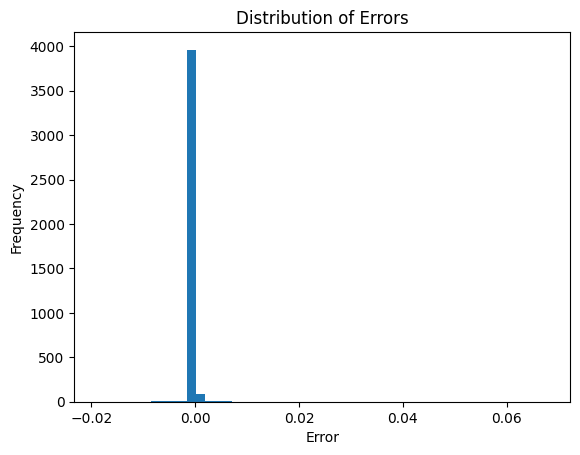

In [122]:
# Compute the errors
errors = [true_p - estimated_p for true_p, estimated_p in zip(true_joint_distribution, estimated_joint_distribution)]

# Analyze the distribution of errors
import matplotlib.pyplot as plt
plt.hist(errors, bins=50)
plt.title('Distribution of Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()


L1 Distance on Split data

In [123]:
# Split the data into subsets
subset1 = dataset[:len(dataset)//2]
subset2 = dataset[len(dataset)//2:]

# Estimate CPTs for each subset
cpts1 = estimate_cpts(model, subset1)
cpts2 = estimate_cpts(model, subset2)

# Compute joint distributions for each subset
estimated_joint_distribution1 = compute_joint_distribution(model, cpts1)
estimated_joint_distribution2 = compute_joint_distribution(model, cpts2)

# Compute L1 distance or KL divergence for each subset
l1_dist1 = l1_distance(true_joint_distribution, estimated_joint_distribution1)
l1_dist2 = l1_distance(true_joint_distribution, estimated_joint_distribution2)
kl_div1 = kl_divergence(true_joint_distribution, estimated_joint_distribution)
kl_div2 = kl_divergence(true_joint_distribution, estimated_joint_distribution)
print("L1 distance for subset 1:", l1_dist1)
print("L1 distance for subset 2:", l1_dist2)
print("KL divergence:", kl_div1)
print("KL divergence:", kl_div2)

L1 distance for subset 1: 0.5888658066746559
L1 distance for subset 2: 0.5875860210431405
KL divergence: 0.4066314923517004
KL divergence: 0.4066314923517004


*Plot True Vs Estimated Probabilities for HasFlu*

true_probs= [0.29425875824822]
estimated_probs= [0.22630356949906735]


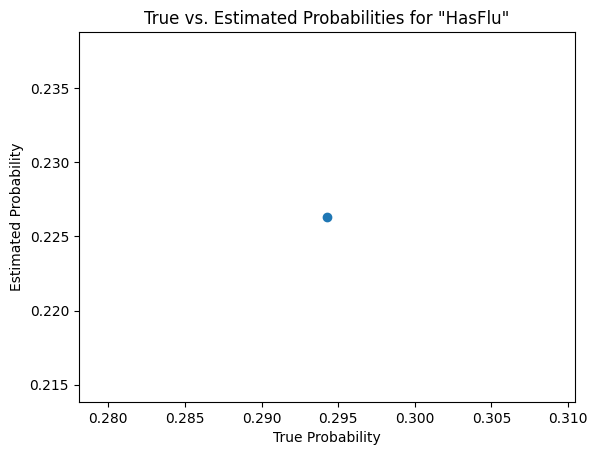

In [124]:
# Choose a specific variable
var = VARIABLE_INDICES["HasFlu"]

# Get the true and estimated probabilities for this variable
true_probs = [p for assignment, p in zip(dataset, true_joint_distribution) if assignment[var]]
estimated_probs = [p for assignment, p in zip(dataset, estimated_joint_distribution) if assignment[var]]
print("true_probs=",true_probs)
print("estimated_probs=",estimated_probs)
# Plot the true vs. estimated probabilities
plt.scatter(true_probs, estimated_probs)
plt.title('True vs. Estimated Probabilities for "HasFlu"')
plt.xlabel('True Probability')
plt.ylabel('Estimated Probability')
plt.show()


Plot True Vs Estimated Probabilities

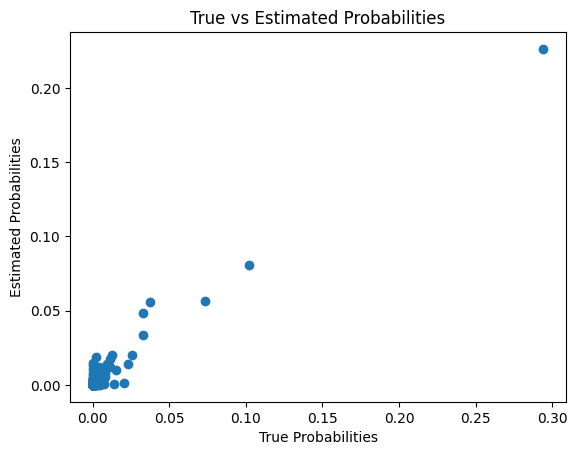

In [125]:
plt.scatter(true_joint_distribution, estimated_joint_distribution)
plt.xlabel('True Probabilities')
plt.ylabel('Estimated Probabilities')
plt.title('True vs Estimated Probabilities')
plt.show()

# 4. Querying

In [126]:
def query(model, cpts, observed_variables, query_variables):
    # Get the number of variables
    num_variables = len(cpts)

    # Initialize the probabilities for the query variables
    query_probs = {var: {True: 0, False: 0} for var in query_variables}

    # Iterate over all possible assignments (each represented as a binary vector)
    for assignment in itertools.product([False, True], repeat=num_variables):
        # Check if this assignment is consistent with the observed variables
        if all(assignment[var] == value for var, value in observed_variables.items()):
            # Compute the probability of this assignment
            prob = 1.0
            for var, parents in model.parent_map.items():
                parent_values = tuple(assignment[p] for p in parents)
                prob *= cpts[var][parent_values][assignment[var]]
            # Add this probability to the probabilities for the query variables
            for var in query_variables:
                query_probs[var][assignment[var]] += prob

    # Normalize the probabilities for the query variables
    for var in query_variables:
        total_prob = sum(query_probs[var].values())
        query_probs[var] = {value: prob / total_prob for value, prob in query_probs[var].items()}

    return query_probs


* What is the probability a patient has flu given they are coughing and have a high fever?

In [127]:
observed_variables = {VARIABLE_INDICES["HasFever"]: True, VARIABLE_INDICES["Coughs"]: True}
query_variables = [VARIABLE_INDICES["HasFlu"]]
result = query(model, cpts, observed_variables, query_variables)
print("P(HasFlu | HasFever=True, Coughs=True) =", result[VARIABLE_INDICES["HasFlu"]])

P(HasFlu | HasFever=True, Coughs=True) = {True: 0.13078502279396564, False: 0.8692149772060344}


* What is the probability distribution over the symptoms given the patient has pneumonia?

In [128]:
# Define the observed variable
observed_variables = {VARIABLE_INDICES["HasPneumonia"]: True}

# Define the query variables
query_variables = [VARIABLE_INDICES["HasRash"], VARIABLE_INDICES["Coughs"], VARIABLE_INDICES["IsFatigued"], VARIABLE_INDICES["Vomits"], VARIABLE_INDICES["HasFever"]]

# Perform the query
result = query(model, cpts, observed_variables, query_variables)

# Print the results
for var in query_variables:
    print(f"P({VARIABLES[var]} | HasPneumonia=True) = {result[var]}")


P(HasRash | HasPneumonia=True) = {True: 0.01736998933049112, False: 0.982630010669509}
P(Coughs | HasPneumonia=True) = {True: 0.19904630917854751, False: 0.8009536908214524}
P(IsFatigued | HasPneumonia=True) = {True: 0.13331418529029546, False: 0.8666858147097045}
P(Vomits | HasPneumonia=True) = {True: 0.07590579959184705, False: 0.9240942004081529}
P(HasFever | HasPneumonia=True) = {True: 0.2503073009932809, False: 0.7496926990067191}


* What is the probability of vomiting in summer?

In [129]:
observed_variables = {VARIABLE_INDICES["IsSummer"]: True}
query_variables = [VARIABLE_INDICES["Vomits"]]
result = query(model, cpts, observed_variables, query_variables)
print("P(Vomits | IsSummer=True) =", result[VARIABLE_INDICES["Vomits"]])


P(Vomits | IsSummer=True) = {True: 0.07583294550116852, False: 0.9241670544988315}


**What is the probability of Having hay fever in summer?**

In [130]:
observed_variables = {VARIABLE_INDICES["IsSummer"]: True}
query_variables = [VARIABLE_INDICES["HasHayFever"]]
result = query(model, cpts, observed_variables, query_variables)
print("P(HasHayFever | IsSummer=Truee) =", result[VARIABLE_INDICES["HasHayFever"]])

P(HasHayFever | IsSummer=Truee) = {True: 0.35101895492370494, False: 0.6489810450762951}


In [131]:
hayfever_cpt = cpts[VARIABLE_INDICES["HasHayFever"]]
print("hayfever_cpt=",hayfever_cpt)

hayfever_cpt= {(False,): {True: 0.17816520928955834, False: 0.8218350546483424}, (True,): {True: 0.35102021493159113, False: 0.6489845192444255}}


**What is the probability of having fever given variables?**


In [132]:
observed_variables = {VARIABLE_INDICES["IsSummer"]: True,VARIABLE_INDICES["HasFlu"]: True, VARIABLE_INDICES["HasPneumonia"]: False, VARIABLE_INDICES["HasRespiratoryProblems"]: False,VARIABLE_INDICES["HasFoodPoisoning"]: True,VARIABLE_INDICES["Vomits"]: False,VARIABLE_INDICES["IsFatigued"]: False,VARIABLE_INDICES["HasHayFever"]: False}
query_variables = [VARIABLE_INDICES["HasFever"]]
result = query(model, cpts, observed_variables, query_variables)
print("P(HasFever | All parent= True) =", result[VARIABLE_INDICES["HasFever"]])

P(HasFever | All parent= True) = {True: 0.28627565634403596, False: 0.713724343655964}


In [133]:
fever_cpt = cpts[VARIABLE_INDICES["HasFever"]]
print("fever_cpt=",fever_cpt)

fever_cpt= {(False, False, False, False, False): {True: 0.25775773877767, False: 0.7422427021783226}, (False, False, True, False, False): {True: 0.2576763024730199, False: 0.7423254600670117}, (False, False, False, True, False): {True: 0.2572755108530724, False: 0.7427267606145683}, (True, False, False, False, False): {True: 0.2576484703059388, False: 0.742371525694861}, (False, True, False, True, False): {True: 0.25851925763320693, False: 0.741488724805428}, (True, False, False, True, True): {True: 0.06558810668998688, False: 0.9344556187144731}, (False, True, False, False, False): {True: 0.25726516501917573, False: 0.7427415869929239}, (False, True, True, True, False): {True: 0.25808934355257673, False: 0.7419427252028349}, (False, False, True, True, False): {True: 0.2579117113485184, False: 0.7420974510271023}, (True, False, True, False, True): {True: 0.061797277876405446, False: 0.9382872601234254}, (True, True, True, True, False): {True: 0.25366262034323983, False: 0.7465466722478